# OLG Model Transition Path Analysis
移行過程分析と結果の可視化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from olg_solver import solve_ss, Setting, SteadyStateResult, TransitionSetting
from olg_transition_solver import create_capital_guess, solve_transition_path

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. OLG Model Setup and Transition Calculation
移行過程の設定と計算

In [2]:
def create_policy_function_boxes(tr_setting, setting):
    """
    移行過程の政策関数とそのインデックスの箱を作成
    - opt_indexes: 政策関数インデックス (NT, NJ, Nl, Na)
    - aprimes: 政策関数実数値 (NT, NJ, Nl, Na)
    """
    shape = (tr_setting.NT, setting.NJ, setting.Nl, setting.Na)
    opt_indexes = np.zeros(shape, dtype=np.int32)
    aprimes = np.zeros(shape, dtype=np.float64)
    return opt_indexes, aprimes

def run_transition_analysis():
    """移行過程分析を実行"""
    print("=== OLG移行過程分析 ===")
    
    # 移行過程の設定を作成
    tr_setting = TransitionSetting(
        NT=100,    # 移行期間
        TT=25,     # 政策変更期間
        psi_ini=0.5,  # 初期所得代替率
        psi_fin=0.25  # 最終所得代替率
    )
    
    tr_setting.print_transition_summary()
    
    # 初期・最終定常状態用のSetting作成
    print("\n=== 定常状態用設定の作成 ===")
    initial_setting, final_setting = tr_setting.create_ss_settings(
        Na=101,        # 資産グリッド数
        Naprime=2001,   # 政策関数用資産グリッド数
    )
    
    print(f"初期定常状態設定: ψ = {initial_setting.psi:.3f}")
    print(f"最終定常状態設定: ψ = {final_setting.psi:.3f}")
    
    # 1. 初期・最終定常状態の計算
    print("\n=== 初期定常状態の計算 ===")
    initial_result = solve_ss(initial_setting)
    mu_ini = initial_result.mu_dist_box
    K_ini = initial_result.K
    
    print("\n=== 最終定常状態の計算 ===")
    final_result = solve_ss(final_setting)
    V_fin = final_result.value_fun_box
    K_fin = final_result.K
    
    # 2. 移行過程の初期設定
    print("\n=== 移行過程の初期設定 ===")
    # K_path = create_capital_guess(tr_setting, K_ini, K_fin)
    # K_path.npyを読み込む
    K_path = np.load("K_path.npy")
    
    # 政策関数とそのインデックスの箱を用意
    opt_indexes, aprimes = create_policy_function_boxes(tr_setting, initial_setting)

    # 移行過程の反復計算
    print("\n=== 移行過程の反復計算 ===")
    converged_K_path = solve_transition_path(
        tr_setting, initial_setting, K_path, opt_indexes, aprimes, V_fin, mu_ini
    )
    
    return tr_setting, initial_result, final_result, converged_K_path, opt_indexes, aprimes

In [3]:
# 移行過程分析を実行
tr_setting, initial_result, final_result, K_path, opt_indexes, aprimes = run_transition_analysis()

=== OLG移行過程分析 ===

=== 移行過程設定サマリー ===
移行期間: 100 期
政策変更収束期間: 25 期
初期所得代替率: 0.500
最終所得代替率: 0.250
移行過程用収束判定閾値: 1.0e-04
移行過程用最大繰り返し回数: 300
移行過程用資本更新調整係数: 0.050

主要期間の所得代替率:
  第1期: ψ = 0.500, τ = 0.178
  第7期: ψ = 0.438, τ = 0.156
  第13期: ψ = 0.375, τ = 0.133
  第25期: ψ = 0.250, τ = 0.089
  第100期: ψ = 0.250, τ = 0.089

=== 定常状態用設定の作成 ===
初期定常状態設定: ψ = 0.500
最終定常状態設定: ψ = 0.250

=== 初期定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 6.803420e-01, errm = 0.000000e+00
Iteration 2: market_diff = 1.284662e-01, errm = 0.000000e+00
Iteration 3: market_diff = 2.420232e-02, errm = 0.000000e+00
Iteration 4: market_diff = 3.463949e-03, errm = 0.000000e+00
Iteration 5: market_diff = 1.147234e-03, errm = 0.000000e+00
\n計算完了! 実行時間: 3.67秒
総イテレーション数: 6
最終市場差: 1.292885e-04
最終人口合計誤差: 0.000000e+00
収束した資本ストック K = 6.1675

=== 最終定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 3.147847e+00, errm = 0.000000e+00
Iteration 2: market_diff = 7.246067e-01, errm = 0.000000e+00
Iteration 3: m

## 2. Capital Path Analysis
資本パスの分析と可視化

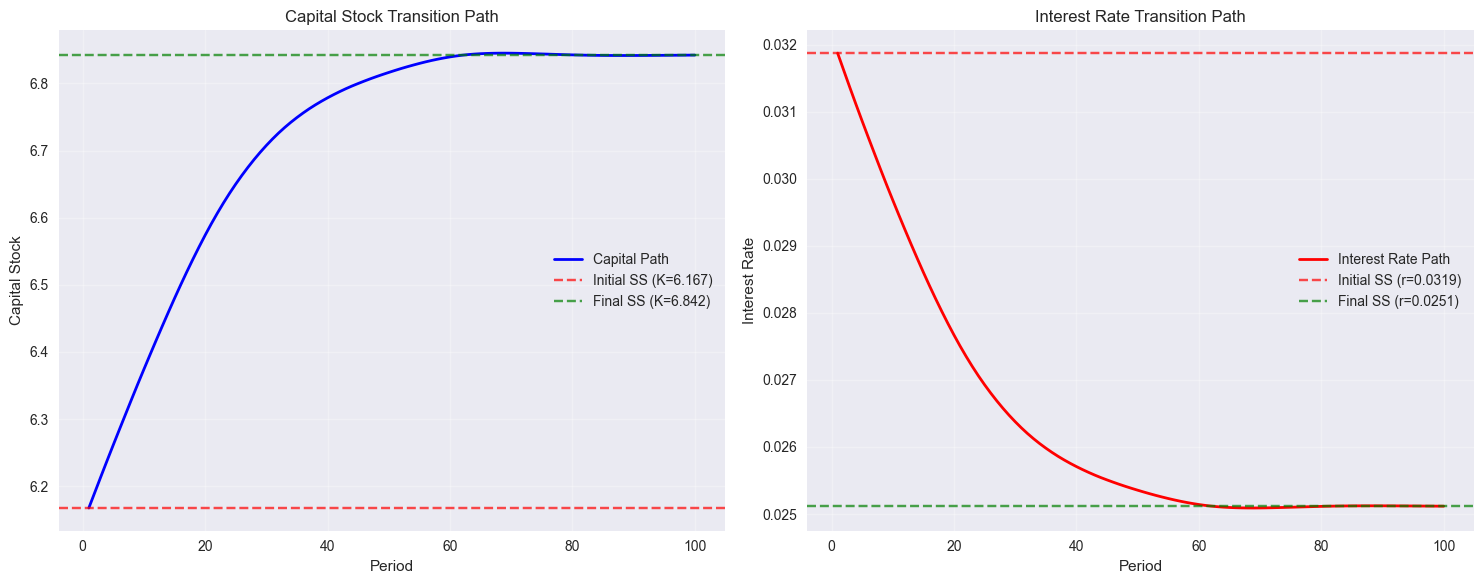

In [4]:
def calculate_factor_prices_path(tr_setting, K_path, initial_setting):
    """移行過程の要素価格を計算"""
    L = initial_setting.Njw / initial_setting.NJ  # 労働供給
    
    r_path = np.zeros(tr_setting.NT)
    w_path = np.zeros(tr_setting.NT)
    
    for t in range(tr_setting.NT):
        K_t = K_path[t]
        r_path[t] = initial_setting.alpha * (K_t / L) ** (initial_setting.alpha - 1) - initial_setting.delta
        w_path[t] = (1 - initial_setting.alpha) * (K_t / L) ** initial_setting.alpha
    
    return r_path, w_path

def plot_capital_path(tr_setting, K_path, initial_result, final_result):
    """資本パスと金利パスをプロット"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 資本パス
    periods = np.arange(1, tr_setting.NT + 1)
    ax1.plot(periods, K_path, 'b-', linewidth=2, label='Capital Path')
    ax1.axhline(y=initial_result.K, color='red', linestyle='--', alpha=0.7, label=f'Initial SS (K={initial_result.K:.3f})')
    ax1.axhline(y=final_result.K, color='green', linestyle='--', alpha=0.7, label=f'Final SS (K={final_result.K:.3f})')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Capital Stock')
    ax1.set_title('Capital Stock Transition Path')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 金利パス
    r_path, _ = calculate_factor_prices_path(tr_setting, K_path, initial_result.hp)
    ax2.plot(periods, r_path, 'r-', linewidth=2, label='Interest Rate Path')
    ax2.axhline(y=initial_result.r, color='red', linestyle='--', alpha=0.7, label=f'Initial SS (r={initial_result.r:.4f})')
    ax2.axhline(y=final_result.r, color='green', linestyle='--', alpha=0.7, label=f'Final SS (r={final_result.r:.4f})')
    ax2.set_xlabel('Period')
    ax2.set_ylabel('Interest Rate')
    ax2.set_title('Interest Rate Transition Path')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_capital_path(tr_setting, K_path, initial_result, final_result)